In [1]:
# Dependencies

from utils import *

In [2]:
# Dataset

d_df = pd.read_pickle('../data/cleaned_data.pkl')
d_df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


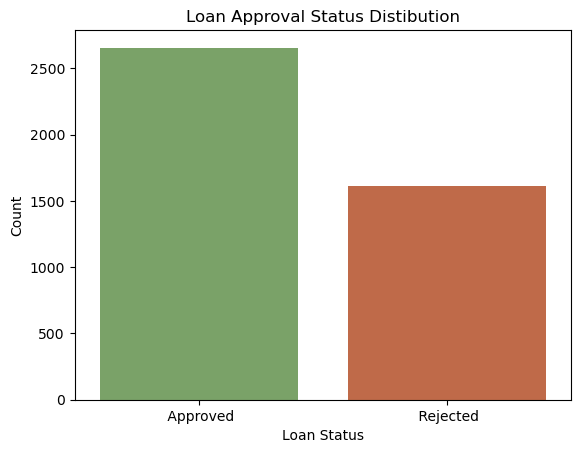

In [3]:
# Exploring the balance of the target variable

palette = {' Approved': '#77AB5F', ' Rejected': '#d36135'}

sns.countplot(x='loan_status', hue='loan_status', data=d_df, palette=palette)
plt.title('Loan Approval Status Distibution')
plt.xlabel('Loan Status'); plt.ylabel('Count')
plt.show()

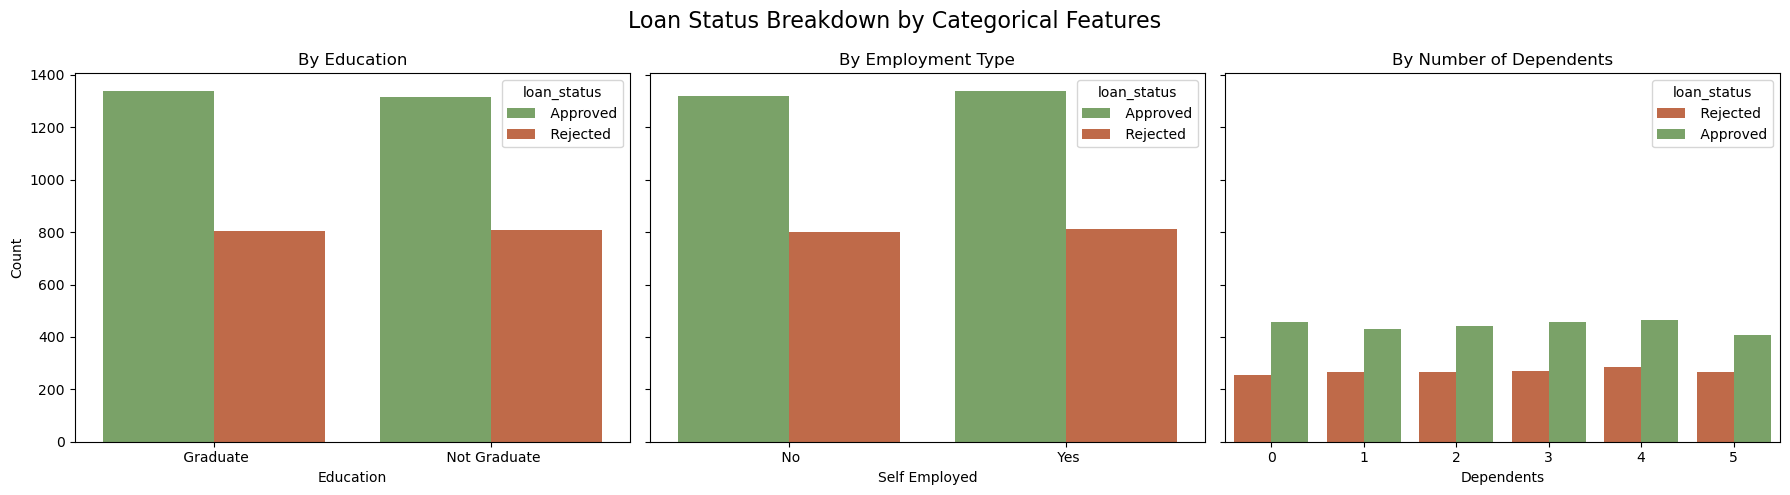

In [4]:
# Categorical Feature Distribution by Loan Status

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.countplot(data=d_df, x='education', hue='loan_status', palette=palette, ax=axes[0])
axes[0].set_title("By Education")
axes[0].set_xlabel("Education")
axes[0].set_ylabel("Count")

sns.countplot(data=d_df, x='self_employed', hue='loan_status', palette=palette, ax=axes[1])
axes[1].set_title("By Employment Type")
axes[1].set_xlabel("Self Employed")
axes[1].set_ylabel("")

sns.countplot(data=d_df, x='no_of_dependents', hue='loan_status', palette=palette, ax=axes[2])
axes[2].set_title("By Number of Dependents")
axes[2].set_xlabel("Dependents")
axes[2].set_ylabel("")

fig.suptitle("Loan Status Breakdown by Categorical Features", fontsize=16)
plt.tight_layout()
plt.show()

#### Observations

1. All categorical variables are balanced i.e. they show similar approval/rejection ratios across their categories
2. No categorical feature shows a strong skew, suggesting no visible bias as this stage
3. Features have limited standalone predictive power but may still contribute when combined with other features or used in non-linear models

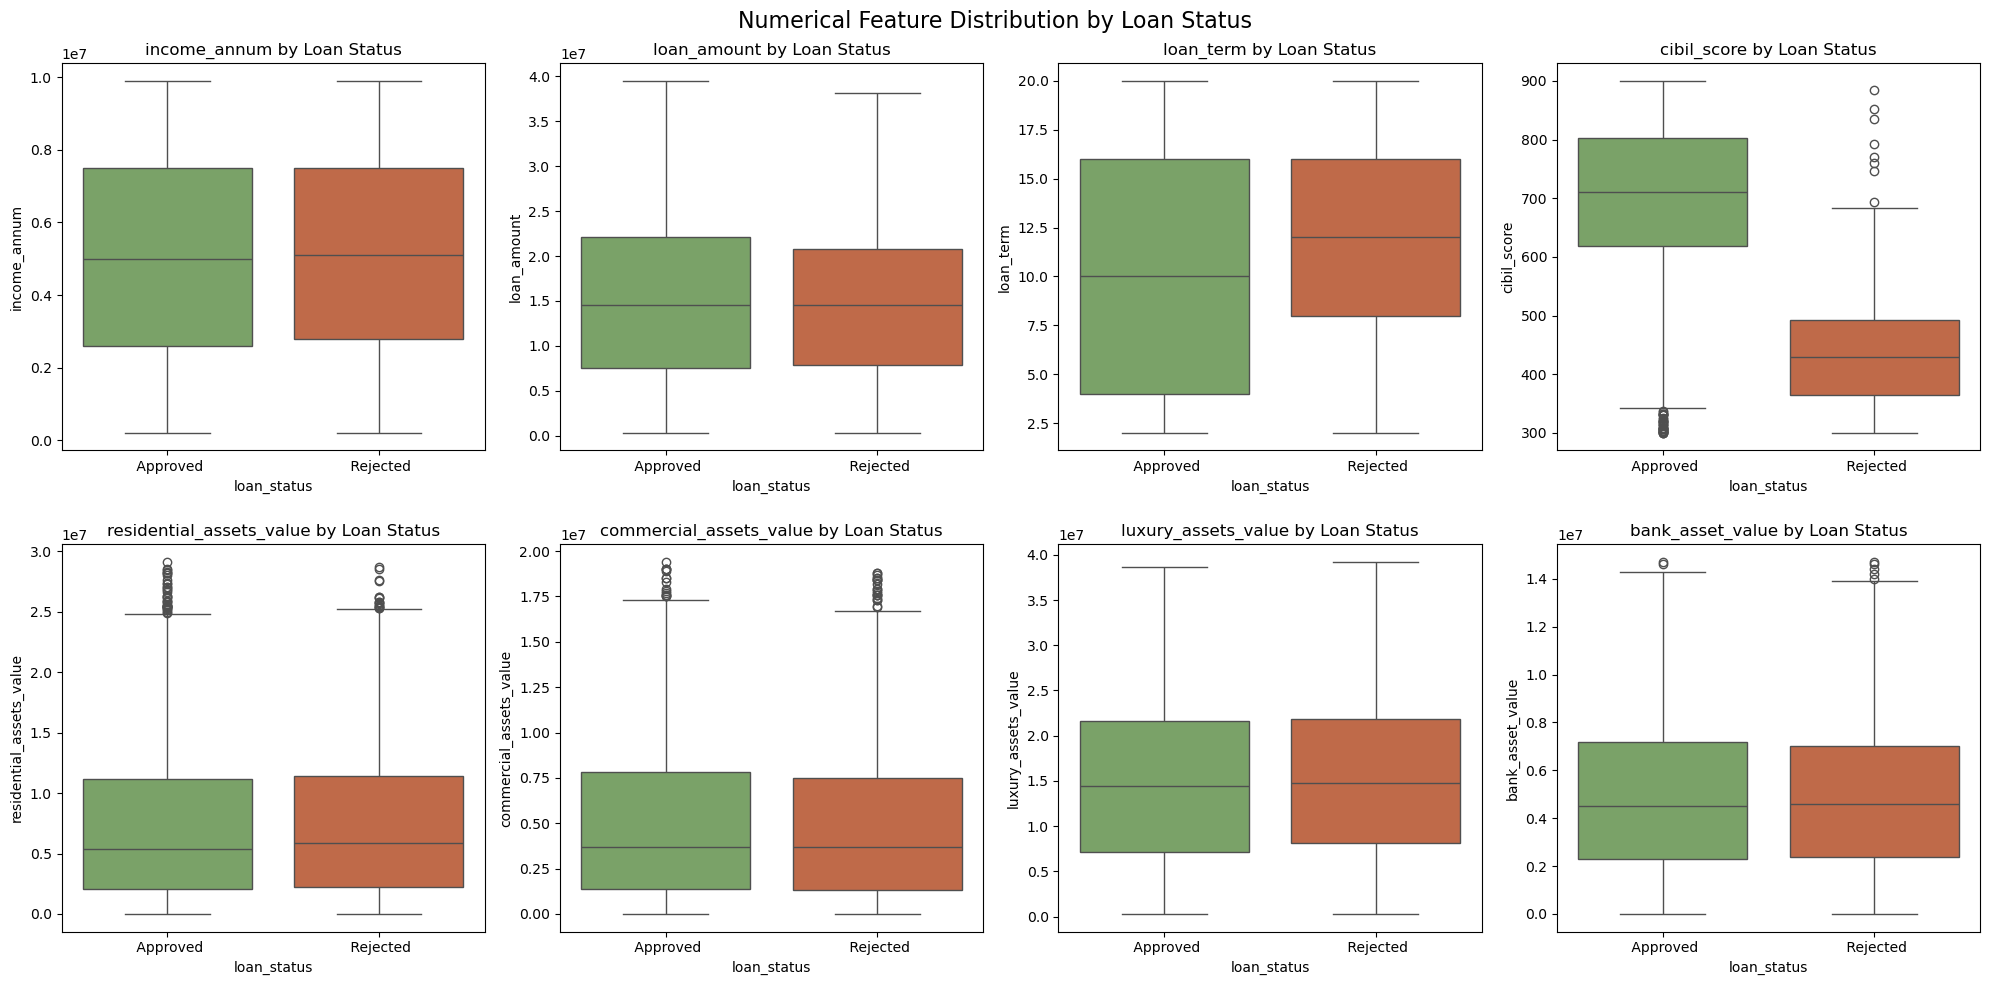

In [5]:
# Numerical Feature Distribution by Loan Status

numerical_features = [
    'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x='loan_status', y=col, hue='loan_status', palette=palette, data=d_df, ax=axes[i])
    axes[i].set_title(f"{col} by Loan Status")

fig.suptitle("Numerical Feature Distribution by Loan Status", fontsize=16)
plt.tight_layout()
plt.show()

#### Observations:

1. Most numerical features would probably not be reliable as independent predictors
2. *cibil_score* is a strong differentiator; however quite a few outliers, potentially needs to be combined with other features to predict
3. Approved *loan_term* tend to have shorter durations

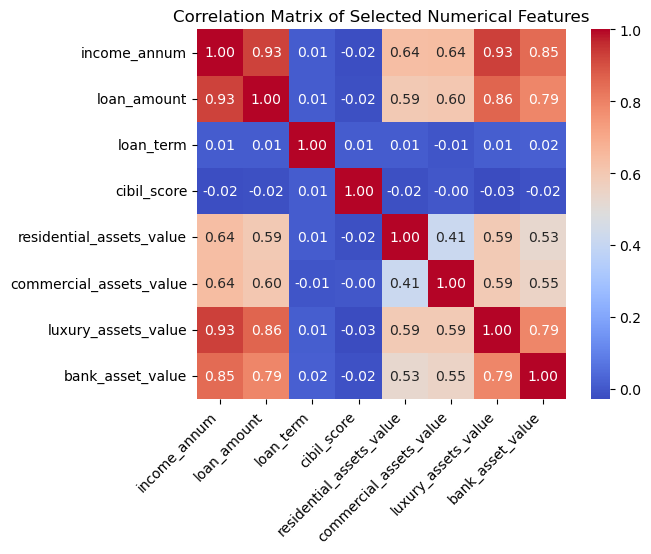

In [6]:
# Correlation Matrix

corr_matrix = d_df[numerical_features].corr()

# Heatmap
plt.figure()
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            square=True, 
            cbar=True,
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Matrix of Selected Numerical Features")
plt.tight_layout
plt.show()

#### Observations

1. *income_amount* and *loan_amount* are highly correlated and of the same scale, but contextually different. Retaining both, should regularize log reg and observe improved performance
2. *income_amount, luxury_assets_value, bank_asset_value* are highgly correlated, of the same scale, and contextually the same. Consider combining into a single wealth index and observe effect on performance
3. *residential_assets_value* and *commercial_assets_value* are interestingly not very correlated, could signify different socio-economic behaviors; worth keeping seperate.
4. *loan_term* and *cibil_score* show very low correlation with all features and also, show great independent predictability potential; keep seperate.

#### Potential Model Variations

1. Original Dataset + Log. Reg. (No Regularization)
2. Original Dataset + Log. Reg. (W/ Regularization)
3. Optimized Dataset + Log. Reg. (No Regularization)
4. Optimized Dataset + Log. Reg. (W/ Regularization)

In [7]:
# Creating a wealth index to optimize # of features

wealth_features = ['income_annum', 'luxury_assets_value', 'bank_asset_value']

d_op_df = d_df.copy()
d_op_df['wealth_index'] = d_op_df[wealth_features].sum(axis=1)

income_idx = d_op_df.columns.get_loc('income_annum')
d_op_df.drop(columns=wealth_features, inplace=True)

cols = list(d_op_df.columns)
cols.insert(1, cols.pop(cols.index('wealth_index')))
d_op_df = d_op_df[cols]

d_op_df.head()

,loan_id,wealth_index,no_of_dependents,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,loan_status
0,1,40300000,2,Graduate,No,29900000,12,778,2400000,17600000,Approved
1,2,16200000,0,Not Graduate,Yes,12200000,8,417,2700000,2200000,Rejected
2,3,55200000,3,Graduate,No,29700000,20,506,7100000,4500000,Rejected
3,4,39400000,3,Graduate,No,30700000,8,467,18200000,3300000,Rejected
4,5,44200000,5,Not Graduate,Yes,24200000,20,382,12400000,8200000,Rejected


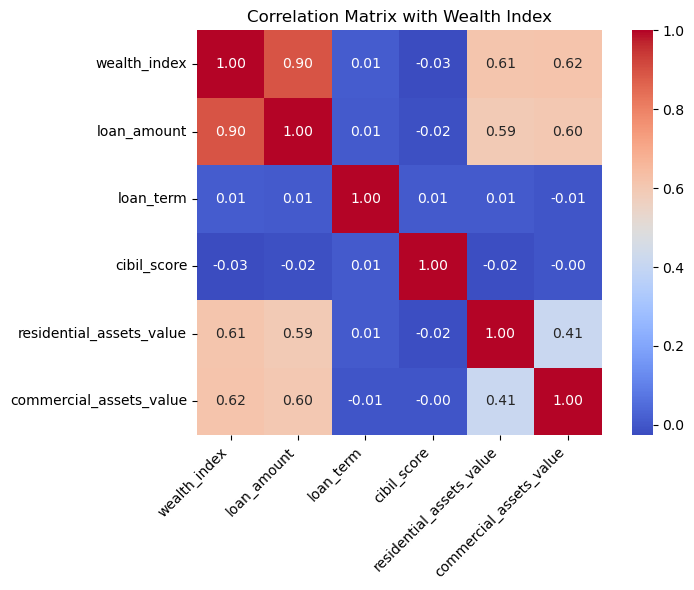

In [8]:
# Review Correlations Again

optimized_numerical_features = [
    'wealth_index', 'loan_amount', 'loan_term', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value'
]

corr_matrix_op = d_op_df[optimized_numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix_op,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar=True,
    xticklabels=corr_matrix_op.columns,
    yticklabels=corr_matrix_op.columns
)
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Matrix with Wealth Index")
plt.tight_layout()
plt.show()

#### Observations

1. Neglible difference in correlations

In [12]:
# Standardizing Numerical Columns

# Original Dataset
d_std_df = d_df.copy()
d_std_df[numerical_features] = StandardScaler().fit_transform(d_df[numerical_features])

d_op_std_df = d_op_df.copy()
d_op_std_df[optimized_numerical_features] = StandardScaler().fit_transform(d_op_df[optimized_numerical_features])

d_op_std_df.head()

,loan_id,wealth_index,no_of_dependents,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,loan_status
0,1,1.042266,2,Graduate,No,1.633052,0.192617,1.032792,-0.780440,2.877289,Approved
1,2,-0.617056,0,Not Graduate,Yes,-0.324414,-0.508091,-1.061051,-0.734296,-0.631921,Rejected
2,3,2.068154,3,Graduate,No,1.610933,1.594031,-0.544840,-0.057515,-0.107818,Rejected
3,4,0.980300,3,Graduate,No,1.721525,-0.508091,-0.771045,1.649818,-0.381263,Rejected
4,5,1.310787,5,Not Graduate,Yes,1.002681,1.594031,-1.264055,0.757698,0.735304,Rejected


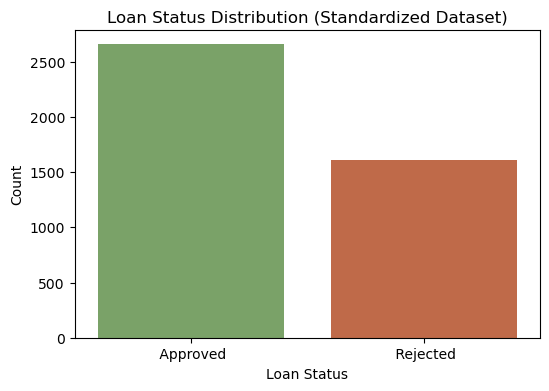

Class Proportions:
 loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


In [14]:
# Recheck class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=d_std_df, x='loan_status', hue='loan_status', palette=palette)
plt.title('Loan Status Distribution (Standardized Dataset)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Print proportion
loan_counts = d_std_df['loan_status'].value_counts(normalize=True)
print("Class Proportions:\n", loan_counts)